<a href="https://colab.research.google.com/github/c-labropoulos/NN-for-lithological-segmentation/blob/main/toRaster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [29]:
#!gdalinfo --version
!pip install geopandas
!pip install rasterio
!pip install pyshp
from osgeo import gdal
from osgeo import ogr
import rasterio
import geopandas as gpd
import shapefile as shp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [30]:
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
from rasterio import features
from rasterio.enums import MergeAlg
from rasterio.plot import show
import numpy as np
def lists_FOR_rasterize(shppath,tiffpath):
 rst_list=list()
 dest_name=list()
 shpfiles = []
 shapenames=[]
 for dirpath, subdirs, files in os.walk(shppath):
    for x in files:
        if x.endswith(".shp"):
            shpfiles.append(os.path.join(dirpath, x))
            shpfiles.append(x.split('.shp', 1)[0])
 shapesList =[None] * len(shpfiles)   
 for dirpath, subdirs, files in os.walk(tiffpath):
    for x in files:
        rst_list.append(os.path.join(dirpath, x))
        dest_name.append(x.split('.tif', 1)[0])
 for name in dest_name:
        rasterpos = dest_name.index(name)
        matching = [s for s in shpfiles if name in s]
        #print(matching[0])
        shapesList[rasterpos]=matching[0]
        shapesList.remove(None)
 #print(f'{rst_list}\n{shapesList}')
 return shapesList,rst_list,dest_name
 
def rasterize(shppath,tiffpath):
  shplist,rasterlist,namesFORDESTINATION=lists_FOR_rasterize(shppath,tiffpath)
  filesnumber =0
  if len(rasterlist)==len(shplist):
     filesnumber=len(shplist)
  else:
    print("SEVERE ERROR : raster list has length of "+str(len(rasterlist))+" and shp files list has length "+str(len(shplist)) )
  for  i in range(filesnumber):
     raster = rasterio.open(rasterlist[i])
     print("RASTER : "+str(rasterlist[i])+" opened ")
     vector = gpd.read_file(shplist[i])
     print("Vector : "+str(shplist[i])+" opened ")
    # create a numeric unique value for each row
     vector['labels_Lit'] = range(0,len(vector))
      # create tuples of geometry, value pairs, where value is the attribute value you want to burn
     geom_value = ((geom,value) for geom, value in zip(vector.geometry, vector["labels_Lit"]))
     # Rasterize vector using the shape and transform of the raster
     rasterized = features.rasterize(geom_value,out_shape = raster.shape,
                                        transform = raster.transform,
                                        all_touched = True,
                                        fill = 0,   # background value
                                        merge_alg = MergeAlg.replace,
                                        dtype = np.int16)
     with rasterio.open(
             "/content/drive/MyDrive/raster_to_be_used/"+namesFORDESTINATION[i]+"_rasterized_vector.tif", "w",
             
             driver = "GTiff",
             transform = raster.transform,
             dtype=rasterized.dtype,
         #  dtype = rasterio.uint8,

            count = 1,
            width = raster.width,
            height = raster.height) as dst:
          dst.write(rasterized, indexes = 1)
   
        
       
    
        
       
       
        
        

           
shape_dir = "/content/drive/MyDrive/LithDatasSHP"
raster_dir='/content/drive/MyDrive/LithDatasTIF'
rasterize(shape_dir,raster_dir)


RASTER : /content/drive/MyDrive/LithDatasTIF/Agios_Georgios.tif opened 
Vector : /content/drive/MyDrive/LithDatasSHP/Agios_Georgios.shp opened 


RASTER : /content/drive/MyDrive/LithDatasTIF/Amfilochia.tif opened 
Vector : /content/drive/MyDrive/LithDatasSHP/Amfilochia.shp opened 
RASTER : /content/drive/MyDrive/LithDatasTIF/Anafi.tif opened 
Vector : /content/drive/MyDrive/LithDatasSHP/Anafi.shp opened 


RASTER : /content/drive/MyDrive/LithDatasTIF/Crete_A.tif opened 
Vector : /content/drive/MyDrive/LithDatasSHP/Crete_A.shp opened 


RASTER : /content/drive/MyDrive/LithDatasTIF/Crete_B.tif opened 
Vector : /content/drive/MyDrive/LithDatasSHP/Crete_B.shp opened 
RASTER : /content/drive/MyDrive/LithDatasTIF/Desfina_.tif opened 
Vector : /content/drive/MyDrive/LithDatasSHP/Desfina_B.shp opened 


RASTER : /content/drive/MyDrive/LithDatasTIF/Desfina_B.tif opened 
Vector : /content/drive/MyDrive/LithDatasSHP/Desfina_B.shp opened 
RASTER : /content/drive/MyDrive/LithDatasTIF/Ermoupoli.tif opened 
Vector : /content/drive/MyDrive/LithDatasSHP/Ermoupoli.shp opened 


RASTER : /content/drive/MyDrive/LithDatasTIF/Exarchos.tif opened 
Vector : /content/drive/MyDrive/LithDatasSHP/Exarchos.shp opened 
RASTER : /content/drive/MyDrive/LithDatasTIF/Grevena.tif opened 
Vector : /content/drive/MyDrive/LithDatasSHP/Grevena.shp opened 


RASTER : /content/drive/MyDrive/LithDatasTIF/Kastro.tif opened 
Vector : /content/drive/MyDrive/LithDatasSHP/Kastro.shp opened 
RASTER : /content/drive/MyDrive/LithDatasTIF/Kimmeria.tif opened 


Vector : /content/drive/MyDrive/LithDatasSHP/Kimmeria.shp opened 


RASTER : /content/drive/MyDrive/LithDatasTIF/Kirko_Bunaras.tif opened 
Vector : /content/drive/MyDrive/LithDatasSHP/Kirko_Bunaras.shp opened 
RASTER : /content/drive/MyDrive/LithDatasTIF/Kithnos_A.tif opened 
Vector : /content/drive/MyDrive/LithDatasSHP/Kithnos_A.shp opened 


RASTER : /content/drive/MyDrive/LithDatasTIF/Kithnos_B.tif opened 
Vector : /content/drive/MyDrive/LithDatasSHP/Kithnos_B.shp opened 
RASTER : /content/drive/MyDrive/LithDatasTIF/Kyprios.tif opened 
Vector : /content/drive/MyDrive/LithDatasSHP/Kyprios.shp opened 


RASTER : /content/drive/MyDrive/LithDatasTIF/Lighurio.tif opened 
Vector : /content/drive/MyDrive/LithDatasSHP/Lighurio.shp opened 


RASTER : /content/drive/MyDrive/LithDatasTIF/LIMENARIA.tif opened 
Vector : /content/drive/MyDrive/LithDatasSHP/LIMENARIA.shp opened 
RASTER : /content/drive/MyDrive/LithDatasTIF/Megara.tif opened 


Vector : /content/drive/MyDrive/LithDatasSHP/Megara.shp opened 
RASTER : /content/drive/MyDrive/LithDatasTIF/Mesorrahi.tif opened 
Vector : /content/drive/MyDrive/LithDatasSHP/Mesorrahi.shp opened 


RASTER : /content/drive/MyDrive/LithDatasTIF/Metsitia_Arta.tif opened 
Vector : /content/drive/MyDrive/LithDatasSHP/Metsitia_Arta.shp opened 


RASTER : /content/drive/MyDrive/LithDatasTIF/Monopigado.tif opened 
Vector : /content/drive/MyDrive/LithDatasSHP/Monopigado.shp opened 


RASTER : /content/drive/MyDrive/LithDatasTIF/Neraidoxori.tif opened 
Vector : /content/drive/MyDrive/LithDatasSHP/Neraidoxori.shp opened 


RASTER : /content/drive/MyDrive/LithDatasTIF/Petroto.tif opened 
Vector : /content/drive/MyDrive/LithDatasSHP/Petroto.shp opened 


RASTER : /content/drive/MyDrive/LithDatasTIF/Skandalo.tif opened 
Vector : /content/drive/MyDrive/LithDatasSHP/Skandalo.shp opened 


RASTER : /content/drive/MyDrive/LithDatasTIF/Tirnavos.tif opened 
Vector : /content/drive/MyDrive/LithDatasSHP/Tirnavos.shp opened 


RASTER : /content/drive/MyDrive/LithDatasTIF/Voras.tif opened 
Vector : /content/drive/MyDrive/LithDatasSHP/Voras.shp opened 


RASTER : /content/drive/MyDrive/LithDatasTIF/XIOS.tif opened 
Vector : /content/drive/MyDrive/LithDatasSHP/XIOS.shp opened 


RASTER : /content/drive/MyDrive/LithDatasTIF/naxos_corected.tif opened 
Vector : /content/drive/MyDrive/LithDatasSHP/naxos_corected.shp opened 


RASTER : /content/drive/MyDrive/LithDatasTIF/Velia.tif opened 
Vector : /content/drive/MyDrive/LithDatasSHP/Velia.shp opened 


In [31]:
vector = gpd.read_file("/content/drive/MyDrive/LithDatasSHP/Anafi.shp")
rst_path='/content/drive/MyDrive/LithDatasTIF/Anafi.tif'
raster = rasterio.open(rst_path)

In [32]:
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
from rasterio import features
from rasterio.enums import MergeAlg
from rasterio.plot import show
import numpy as np
# create a numeric unique value for each row
#col_list =  list(vector["labels_Lit"])
#print(col_list)

vector['labels_Lit'] = range(0,len(vector))
#print(vector['labels_Lit'])

# create tuples of geometry, value pairs, where value is the attribute value you want to burn
geom_value = ((geom,value) for geom, value in zip(vector.geometry, vector["labels_Lit"]))

# Rasterize vector using the shape and transform of the raster
rasterized = features.rasterize(geom_value,
                                out_shape = raster.shape,
                                transform = raster.transform,
                                all_touched = True,
                                fill = 0,   # background value
                                merge_alg = MergeAlg.replace,
                                dtype = np.int16)

#print(rasterized)
#import geopandas as gpd
#df = gpd.read_file('../../Datasets/italy-points-shape/points.shp')
#df.head()

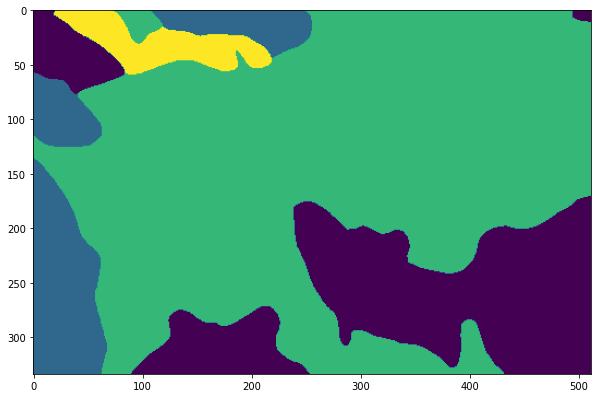

In [33]:
# Plot raster
fig, ax = plt.subplots(1, figsize = (10, 10))
#handles, labels = ax.get_legend_handles_labels(vector['labels_Lit'])
#ax.legend(labels,loc='upper right')
show(rasterized, ax = ax)
plt.gca()
with rasterio.open(
        "/content/drive/MyDrive/raster_to_be_used/Anafi_rasterized_vector.tif", "w",
        driver = "GTiff",
        transform = raster.transform,
        dtype=rasterized.dtype,
      #  dtype = rasterio.uint8,

        count = 1,
        width = raster.width,
        height = raster.height) as dst:
    dst.write(rasterized, indexes = 1)

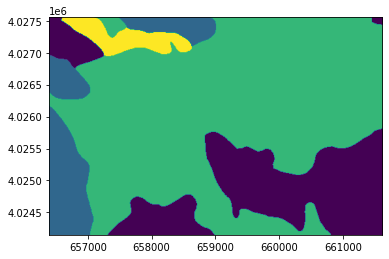

<AxesSubplot:>

In [34]:
rst_path='/content/drive/MyDrive/raster_to_be_used/Anafi_rasterized_vector.tif'
from osgeo import gdal
raster = rasterio.open(rst_path)
#raster.RasterCount
show(raster)